# Ride Price prediction project


In [70]:
import kagglehub
import os
from matplotlib import pyplot as plt
import seaborn as sns

path = kagglehub.dataset_download("ravi72munde/uber-lyft-cab-prices")
print(os.listdir(path))
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'uber-lyft-cab-prices' dataset.
['Cab-Weather Data', 'cab-weather data', 'cab_rides.csv', 'weather.csv']
Path to dataset files: /kaggle/input/uber-lyft-cab-prices


In [71]:
import pandas as pd
df=pd.read_csv(os.path.join(path, "cab_rides.csv"))
df.describe()

,distance,time_stamp,price,surge_multiplier
count,693071.000000,6.930710e+05,637976.000000,693071.000000
mean,2.189430,1.544046e+12,16.545125,1.013870
std,1.138937,6.891925e+08,9.324359,0.091641
min,0.020000,1.543204e+12,2.500000,1.000000
25%,1.280000,1.543444e+12,9.000000,1.000000
50%,2.160000,1.543737e+12,13.500000,1.000000
75%,2.920000,1.544828e+12,22.500000,1.000000
max,7.860000,1.545161e+12,97.500000,3.000000


In [72]:
df.isna().sum()

,0
distance,0
cab_type,0
time_stamp,0
destination,0
source,0
price,55095
surge_multiplier,0
id,0
product_id,0
name,0


In [73]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


# Data Preprocessing

1. Adding datetime from timestamp for easier processing .
2. Extract hour of the day to determine peak hours.

In [74]:
df['date_time']=pd.to_datetime(df["time_stamp"], unit='ms')
df['hour_of_day']=df['date_time'].dt.hour
df['day']=df['date_time'].dt.day_of_week
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,hour_of_day,day
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890,9,6
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677,2,1
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.198,1,2
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749,4,4
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223,3,3


## Understansing the data

## Trips per hour

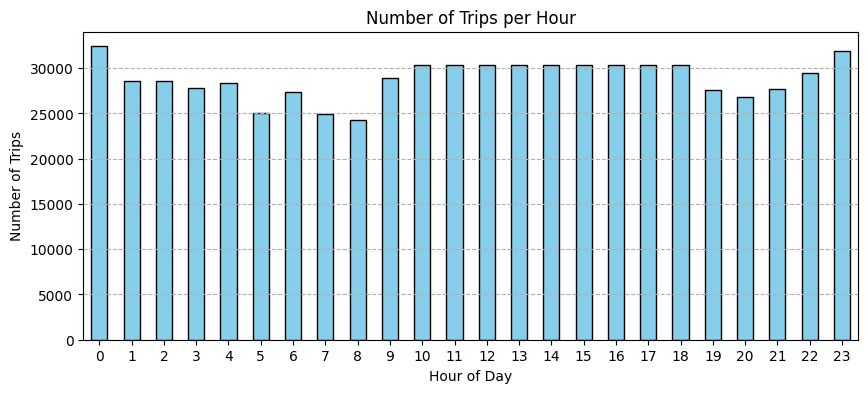

In [75]:
trips_per_hour = df.groupby('hour_of_day').size() # Plot 
trips_per_hour.plot(kind='bar', color='skyblue', edgecolor='black',figsize=(10,4)) 

plt.title("Number of Trips per Hour") 
plt.xlabel("Hour of Day") 
plt.ylabel("Number of Trips") 
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle="--") 
plt.show()



## Distance vs price

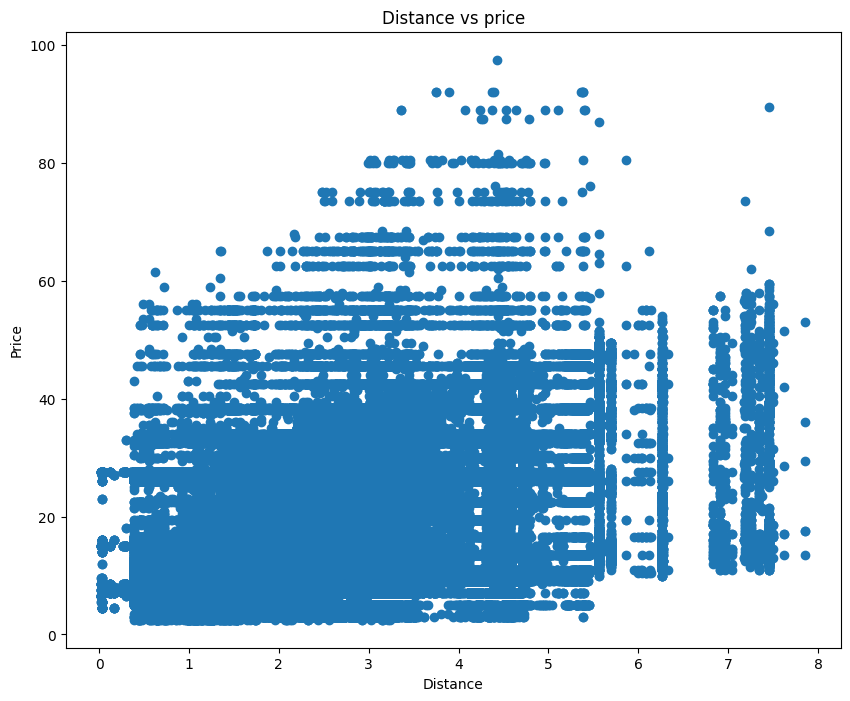

In [76]:


plt.figure(figsize=(10,8))
plt.title( 'Distance vs price')
plt.scatter(x=df['distance'],y=df['price'])
plt.xlabel("Distance") 
plt.ylabel("Price") 
plt.show()

## Trips per day of the week

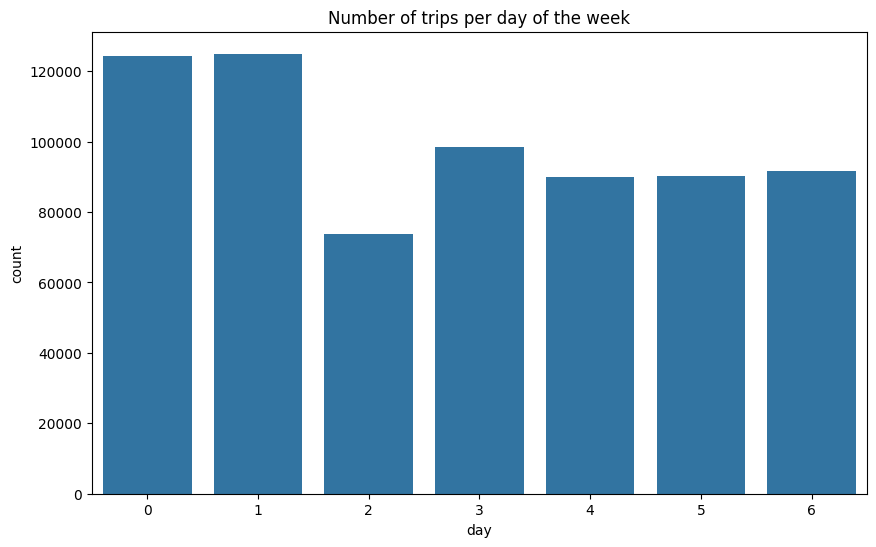

In [77]:


plt.figure(figsize=(10,6))
sns.countplot(x=df['day'])
plt.title("Number of trips per day of the week")
plt.show()

# Cleaning

## Handling missing values

In [78]:
from sklearn.impute import SimpleImputer
df[['price']]=SimpleImputer(strategy="median").fit_transform(df[['price']])
df[['price']].isna().sum()

,0
price,0


## Outliers

In [79]:
df = df[df["distance"] < df["distance"].quantile(0.995)]
df = df[df["price"] < df["price"].quantile(0.995)]

## Feature Engineering

In [80]:
df["day_of_week"] = df["date_time"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5,6]).astype(int)
df["is_rush_hour"] = df["hour_of_day"].isin([7,8,9,16,17,18]).astype(int)

Data encoding

In [81]:
from sklearn.preprocessing import LabelEncoder as LE
df.columns
le=LE()
categorical_cols=['cab_type','source','destination','product_id','name']
for category in categorical_cols:
    df[category]=le().fit_transform( df[category].astype(int))
#ID being an object type is causing errors
df['destination'].unique().sum()

TypeError: 'LabelEncoder' object is not callable

# Preparing for training


In [82]:
from sklearn.model_selection import train_test_split
X=df.drop(columns=['time_stamp','price','date_time'])
Y=df['price']
cols=X.select_dtypes(include="object").columns.to_list()
for col in cols:
    X[col]=le.fit_transform(X[col].astype(str))
x_train,x_test,y_train, y_test=train_test_split(X,Y)


## Regression

In [83]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
model=lr.fit(x_train, y_train)
prediction = model.predict(x_test)